# Objective: generate video from text description

- Download dataset UCF-101 https://www.crcv.ucf.edu/data/UCF101.php. It's an action recognition dataset, with input videos and corresponding action classes.

- Download MoCoGAN code (conditional GAN model for video generation, with categorical condition): https://github.com/DLHacks/mocogan

- Train MoCoGAN on UCF-101: the resulting model will be able to generate videos from action classes

- Download S2VT pre-trained model (video-to-text model): https://vsubhashini.github.io/s2vt.html

  - Note: S2VT uses the Caffe library. Install the library (you don't need to train the model).

- Process each video in UCF-101 and get the corresponding text description. Create a dataset with input=text description and output=action class.

- Train an LSTM classifier (similar to the one used in class for sentiment analysis) to classify text descriptions into actions. Report the performance.

- The final model works by: getting an input text description by the user, converting it into an action class with the LSTM model, and using the action class as a condition to MoCoGAN.

Note: the model will not be precise in generating video details, since conditioning is based on the class only. 
For example:

"I'm running in the park" -> action: running

"My dog is running on the beach" -> action: running

Output videos will not actually take into account the context, but only the action.

In [1]:
import os
import torch
import numpy as np
from glob import glob
from torch.utils.data import DataLoader

import skvideo.io

In [2]:
data_dir = "/home/carlo/Documents/Cognitive Computing/Text2VideoGAN/mocogan/resized_data"
image_dir_name = "*"
image_paths = glob(os.path.join(data_dir, image_dir_name, "*"))

if (len(image_paths) < 1):
    data_dir = "/home/carlo/Documenti/Text2VideoGAN/mocogan/resized_data"
    image_paths = glob(os.path.join(data_dir, image_dir_name, "*"))
    
image_paths[0]

'/home/carlo/Documenti/Text2VideoGAN/mocogan/resized_data/Haircut/v_Haircut_g20_c05.mp4'

In [3]:
original_video = skvideo.io.vread(image_paths[0], 96, 96)
video =  original_video.transpose(3, 0, 1, 2) / 255.0

## Trying to display a video changed by transposing it

In [4]:

dirToSave = "./"
fileName = "transposedVideo.mp4"
#filepath = os.path.join(dirToSave, fileName)

toSaveVideo = original_video.astype(np.uint8)
skvideo.io.vwrite(fileName, toSaveVideo)



## Import the necessary dependencies to train the model

In [14]:
import imageio
import pylab
import math
import numpy as np
import skvideo.io
from glob import glob
filenames = glob("/home/carlo/Documenti/Text2VideoGAN/mocogan/resized_data/*/*")

from datetime import datetime

def readImageio(filename, frame= 0,show= False):

    reader = imageio.get_reader(filename,  'avbin')
    
    #nframes = math.floor(vid.get_meta_data()['fps'] * vid.get_meta_data()['duration'])
    #shape = vid.get_meta_data()['size']
    #n_channels = 3

    #for i, im in enumerate(vid):
        #print(i, type(im), type(np.asarray(im)), np.asarray(im).shape)

    image = reader.get_data(frame)
        
    if show:
        fig = pylab.figure()
        fig.suptitle('image', fontsize=20)
        pylab.imshow(image)
        pylab.show()
        
    return np.asarray(image)

def printMetaData(filename):
    
    meta = {}
    with imageio.get_reader(filename, 'ffmpeg') as reader:
        meta = reader.get_meta_data()
    
    print(meta)
    
    return meta

def composeVideoImageio(filename):
    
    #reader = imageio.get_reader(filename,  'ffmpeg')
    
    with imageio.get_reader(filename, 'ffmpeg') as reader:
    
        #nframes = math.floor(reader.get_meta_data()['fps'] * reader.get_meta_data()['duration'])
        
        '''print(reader.get_meta_data()['fps'], reader.get_meta_data()['duration'],
            reader.get_meta_data()['fps'] * reader.get_meta_data()['duration'],
            math.ceil(reader.get_meta_data()['fps'] * reader.get_meta_data()['duration']),
            int(reader.get_meta_data()['fps'] * reader.get_meta_data()['duration']))'''
        
        shape = reader.get_meta_data()['size']

        #videodata = np.zeros((nframes, shape[0], shape[1], 3), dtype= np.uint8)

        frames = []
        
        for idx, img in enumerate(reader):
            try:
                frames.append(img)
            
            except Error as err:
                print(Error)
            #try:
            #    videodata[idx, :, :, :] = img
            #except IndexError as _:
            #    videodata.resize((nframes + 1, shape[0], shape[1], 3))
            #    videodata[idx, :, :, :] = img
            
    if not reader.closed:
        reader.close()
        
    videodata = np.array(frames, dtype= np.uint8)
    
    #del reader
            
    return videodata
        

def measurePerformance(method, args):
    start = datetime.now()
    
    res = method(args)
    
    end = datetime.now()
    
    return (end - start ).total_seconds(), res

imageio.plugins.avbin.download()

try:
    seconds1, res = measurePerformance( composeVideoImageio,filenames[0])
    seconds2, res_ = measurePerformance( skvideo.io.vread, filenames[0])
except IndexError as _:
    filenames = glob("/home/carlo/Documents/Cognitive Computing/Text2VideoGAN/mocogan/resized_data/*/*")
    seconds1, res = measurePerformance( composeVideoImageio, filenames[0])
    seconds2, res_ = measurePerformance( skvideo.io.vread, filenames[0])
    
print(f"Imageio: {seconds1}s, Skvideo: {seconds2}s")

print(res_.shape, res.shape)

"""for arrs in (res - res_):
    for arr in arrs:
        for els in arr:
            for el in els:
                assert el == 0.0"""

skmean = res_.mean()
imgmean = res.mean()

print(f"Imageio: {imgmean}, Skvideo: {skmean}")

assert np.isclose(skmean - imgmean, 0)

Imageio: 0.079408s, Skvideo: 0.139104s
(201, 96, 96, 3) (201, 96, 96, 3)
Imageio: 79.99903747322416, Skvideo: 79.99903747322416


In [3]:
import torch
import torch.nn as nn


emb = nn.Embedding(101, 6)
t = torch.LongTensor([0])
t1 = torch.LongTensor([1])
t2 = torch.LongTensor([100])
t3 = torch.LongTensor([0])

print( emb(t), emb(t1), emb(t2), emb(t3) )

class Model(nn.Module):
    
    def __init__(self, embEls, embSize):
        super().__init__()
        self.embedding = nn.Embedding(embEls, embSize)
        
model = Model(101, 6)
print(*model.parameters())

print(torch.randn(128,60))

tensor([[ 1.2339, -0.2296,  1.1954,  0.0766,  1.8319, -1.5679]],
       grad_fn=<EmbeddingBackward>) tensor([[ 0.5597, -1.0115, -1.2876,  1.6354, -0.6230,  2.2848]],
       grad_fn=<EmbeddingBackward>) tensor([[ 0.2361,  0.3149, -0.5461, -0.3276, -0.0337,  1.5490]],
       grad_fn=<EmbeddingBackward>) tensor([[ 1.2339, -0.2296,  1.1954,  0.0766,  1.8319, -1.5679]],
       grad_fn=<EmbeddingBackward>)
Parameter containing:
tensor([[ 4.7921e-02, -5.3535e-01, -2.2795e+00, -1.5989e+00, -1.9442e+00,
          1.1909e-02],
        [ 1.1355e+00,  7.3753e-01,  8.8629e-01, -1.5201e+00,  1.3649e+00,
         -8.9513e-01],
        [-1.6694e+00, -9.3621e-01,  4.1999e-02,  5.9370e-01,  4.8361e-01,
          1.3135e-01],
        [-5.7331e-01,  4.8860e-01, -8.3437e-02, -4.7477e-01,  1.4459e-01,
         -1.8485e+00],
        [ 3.9649e-01,  2.0868e-01, -1.2799e-01, -4.7812e-01, -4.4858e-02,
         -1.6832e+00],
        [-4.4351e-01, -1.9429e-01,  1.2704e-02, -6.7517e-01, -3.4294e-01,
         -1.184

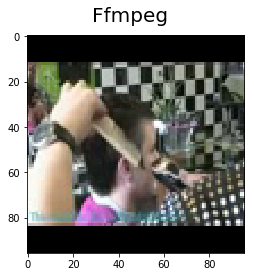

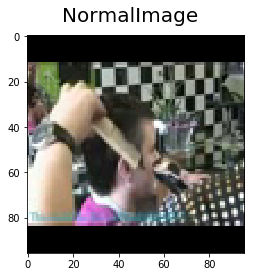

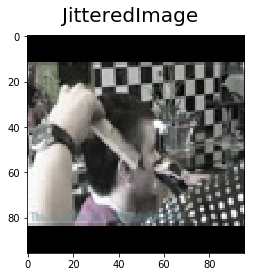

In [15]:
from torch_videovision.videotransforms.video_transforms import ColorJitter

jitter = ColorJitter(brightness=1, contrast=0.9, saturation=1, hue=-0.5)

jitteredRes_ = jitter(res_)

fig = pylab.figure()
fig.suptitle('Ffmpeg', fontsize=20)
pylab.imshow(res[2])
fig = pylab.figure()
fig.suptitle('NormalImage', fontsize=20)
pylab.imshow(res_[1])
fig = pylab.figure()
fig.suptitle('JitteredImage', fontsize=20)
pylab.imshow(jitteredRes_[0])
pylab.show()

def showImg(frame, title = "Image"):
    fig = pylab.figure()
    fig.suptitle(title, fontsize=20)
    pylab.imshow(frame)
    pylab.show()

## Test all the dataset

In [17]:
print("-"*50)
for idx, filename in enumerate(filenames):
    readVideo = composeVideoImageio(filename)
    readVideo_ = skvideo.io.vread(filename)        
    try:
        assert readVideo.mean() == readVideo_.mean()
        assert readVideo.shape[0] == readVideo_.shape[0]
            
    except AssertionError as _:
        print(f"Video: {filename} || Mean for Imageio: {readVideo.mean()} || Shape for Imageio: {readVideo.shape}")
        print(f"Video: {filename} || Mean for Skvideo: {readVideo_.mean()} || Shape for Skvideo: {readVideo_.shape}")
        printMetaData(filename)
        showImg(readVideo[readVideo.shape[0] - 1], f"{filename}-Frame {readVideo.shape[0] - 1}-Imageio")
        showImg(readVideo_[readVideo_.shape[0] - 1], f"{filename}-Frame {readVideo_.shape[0] - 1}-Skvideo")
        print("-"*50)
        
    if idx % 100 == 0:
        print(f"Processed {idx + 1} videos")
        
print("Check Completed.")

--------------------------------------------------
Processed 1 videos
Processed 101 videos
Processed 201 videos
Processed 301 videos
Processed 401 videos
Processed 501 videos
Processed 601 videos
Processed 701 videos
Processed 801 videos
Processed 901 videos
Processed 1001 videos
Processed 1101 videos
Processed 1201 videos
Processed 1301 videos
Processed 1401 videos
Processed 1501 videos
Processed 1601 videos
Processed 1701 videos
Processed 1801 videos
Processed 1901 videos
Processed 2001 videos
Processed 2101 videos
Processed 2201 videos
Processed 2301 videos
Processed 2401 videos
Processed 2501 videos
Processed 2601 videos
Processed 2701 videos
Processed 2801 videos
Processed 2901 videos
Processed 3001 videos
Processed 3101 videos
Processed 3201 videos
Processed 3301 videos
Processed 3401 videos
Processed 3501 videos
Processed 3601 videos
Processed 3701 videos
Processed 3801 videos
Processed 3901 videos
Processed 4001 videos
Processed 4101 videos
Processed 4201 videos
Processed 4301 